# estimate $p(\theta_g)$ using a normalizing flow

In [1]:
import os
import h5py 
import numpy as np

In [2]:
import torch
import torch.utils.data
import torch.optim as optim
from nflows import transforms, distributions, flows

In [3]:
import corner as DFM
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

## load CAMELS data set

In [5]:
dat_dir = '/tigress/chhahn/cgpop/'
f = h5py.File(os.path.join(dat_dir, 'tng.snap33.subfind.galaxies.LHC.hdf5'), 'r')
props = f['props'][...].T
f.close()

In [6]:
props[:,6] = np.log10(props[:,6])
props[:,7] = np.log10(props[:,7])
props[:,13] = np.log10(props[:,13])
props[:,17] = np.log10(props[:,17])

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [7]:
props = props[np.isfinite(props[:,6])]

In [8]:
# Om, s8, Asn1, Aagn1, Asn2, Aagn2, Mg, Mstar, Mbh, Mtot, Vmax, Vdisp, Zg, Zs, SFR, J, Vel, Rstar, Rtot, Rvmax,
# absmag U, B, V, K, g, r, i, z
lbls = [r'$\Omega_m$', r'$\sigma_8$', r'$A_{\rm SN1}$', r'$A_{\rm AGN1}$', r'$A_{\rm SN2}$', r'$A_{\rm AGN2}$', 
        r'$\log M_g$', r'$\log M_*$', r'$M_{\rm BH}$', r'$M_{\rm tot}$', r'$V_{\rm max}$', r'$V_{\rm disp}$', 
        r'$Z_g$', r'$\log Z_*$', 'SFR', 'J', 'V', r'$\log R_*$', r'$R_{\rm tot}$', r'$R_{\rm vmax}$', 
        r'$U$ absmag', r'$B$ absmag', r'$V$ absmag', r'$K$ absmag', r'$g$ absmag', r'$r$ absmag', r'$i$ absmag', 
        r'$z$ absmag']

In [9]:
icosmo = [0, 1, 2, 3, 4, 5] # cosmological/hydro parameters
igals = [6, 7, 10, 13, 17] # intrinsic properties of galaixes (Mg, M*, Vmax, Z*, R*)
iobs = [-4, -3, -2, -1]

# $p(M_{\rm gas}, M_*, V_{\rm max}, Z_*, R_*)$


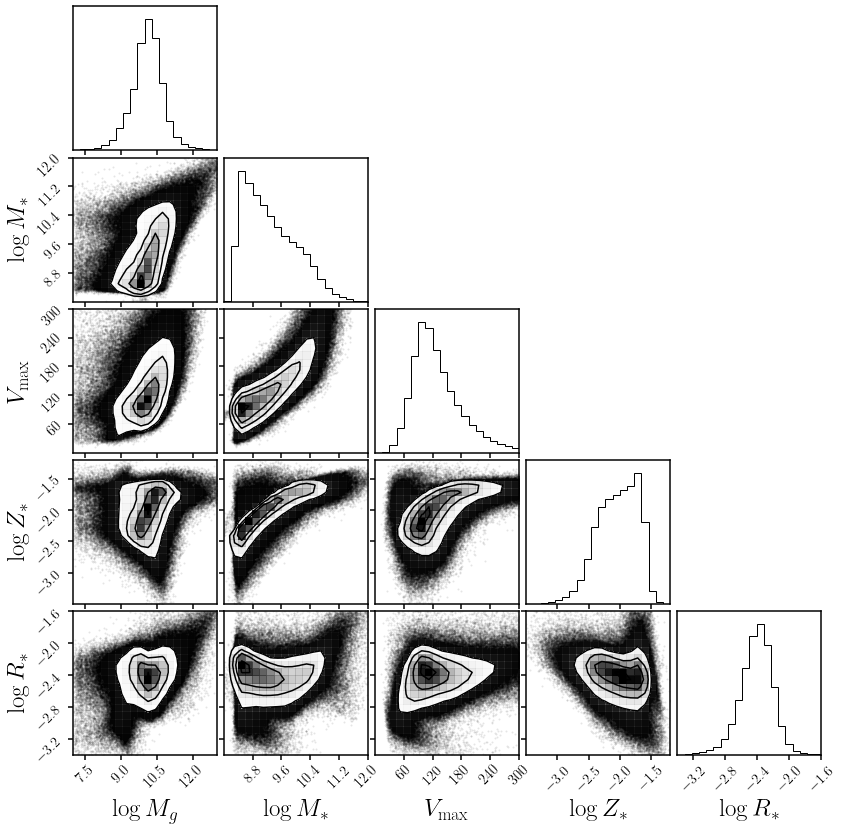

In [10]:
fig = DFM.corner(props[:,igals], range=[(7., 13.), (8., 12.), (0., 300), (-3.5, -1.2), (-3.4, -1.6)],
                 labels=[lbls[i] for i in igals], label_kwargs={'fontsize': 25})

# train normalizing flow

In [12]:
ishuffle = np.arange(props.shape[0])
np.random.shuffle(ishuffle)

N_train = int(0.8 * props.shape[0])
x_train = torch.utils.data.DataLoader(torch.as_tensor(props[:,igals][ishuffle[:N_train]]).to(device), 
                                      batch_size=128, shuffle=True)

N_valid = int(0.1 * props.shape[0])
x_valid = torch.utils.data.DataLoader(torch.as_tensor(props[:,igals][ishuffle[N_train:N_train+N_valid]]).to(device), 
                                      batch_size=128, shuffle=True)

x_test = props[:,igals][ishuffle[N_train+N_valid:]]

In [27]:
nhidden = 128
nblocks = 2
ntransf = 5
lrate = 1e-2

transform_list = []
for _ in range(ntransf): 
    block = [
        transforms.MaskedAffineAutoregressiveTransform(
            features=5, 
            num_blocks=nblocks, 
            hidden_features=nhidden),
        transforms.RandomPermutation(features=5)]
    transform_list += block
    
base_distribution = distributions.StandardNormal(shape=[5])
transform = transforms.CompositeTransform(transform_list)
flow = flows.Flow(transform=transform, distribution=base_distribution)
flow.to(device)

optimizer = optim.Adam(flow.parameters(), lr=lrate)
# set up scheduler 
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, lrate, total_steps=1000)

best_valid_loss, best_epoch = np.inf, 0 
train_losses, valid_losses = [], []
for epoch in range(1000): 
    flow.train() 
    train_loss = 0.   
    for _x in x_train: 
        optimizer.zero_grad()
        loss = -flow.log_prob(_x).mean()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= len(x_train.dataset)

    with torch.no_grad():
        valid_loss = 0.
        for _x in x_valid:
            loss = -flow.log_prob(_x).mean()
            valid_loss += loss.item()
        valid_loss /= len(x_valid.dataset)
        
    if epoch % 10 == 0: 
        print('Epoch %i Training Loss %.2e Validation Loss %.2e' % (epoch, train_loss, valid_loss))

    if valid_loss < best_valid_loss: 
        best_valid_loss = valid_loss
        best_epoch = epoch

    if epoch > best_epoch + 20: break 
    scheduler.step()

Epoch 0 Training Loss 9.37e+04 Validation Loss 4.49e-02
Epoch 10 Training Loss 3.82e-02 Validation Loss 3.72e-02
Epoch 20 Training Loss 3.65e-02 Validation Loss 3.61e-02
Epoch 30 Training Loss 3.62e-02 Validation Loss 3.61e-02
Epoch 40 Training Loss 3.61e-02 Validation Loss 3.59e-02
Epoch 50 Training Loss 3.60e-02 Validation Loss 3.59e-02
Epoch 60 Training Loss 3.59e-02 Validation Loss 3.60e-02
Epoch 70 Training Loss 3.60e-02 Validation Loss 3.59e-02


# validate $p(\theta^g)$

In [28]:
thetag_prime = flow.sample(10000)

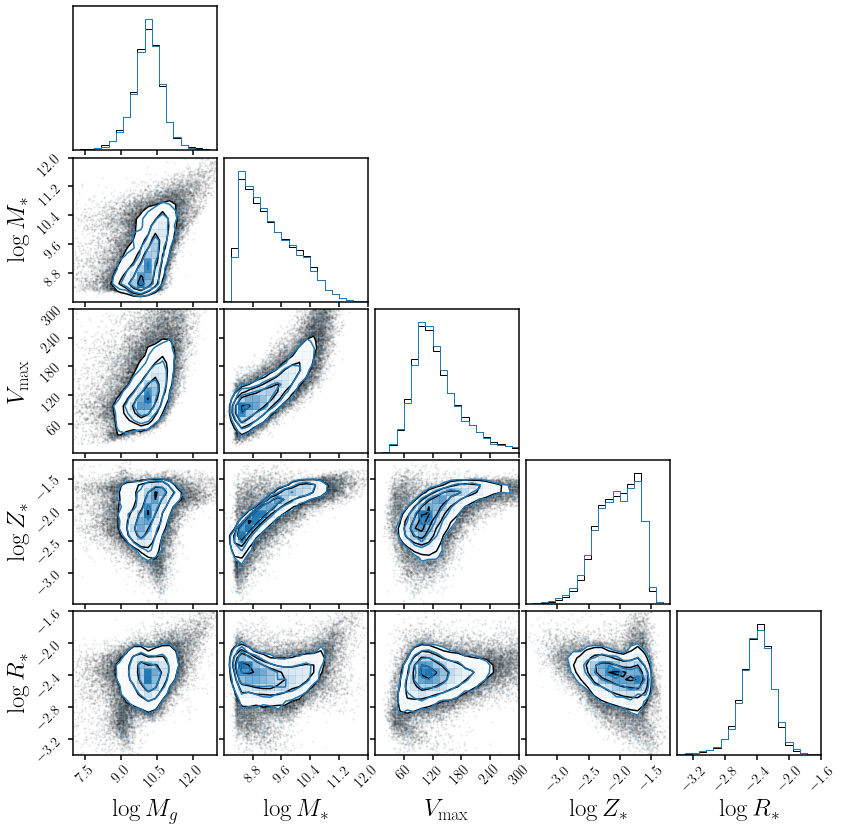

In [29]:
fig = DFM.corner(x_test, color='k', hist_kwargs={'density': True},
                 range=[(7., 13.), (8., 12.), (0., 300), (-3.5, -1.2), (-3.4, -1.6)],
                 labels=[lbls[i] for i in igals], label_kwargs={'fontsize': 25})
_ = DFM.corner(thetag_prime.cpu().detach().numpy(), color='C0', hist_kwargs={'density': True},
               range=[(7., 13.), (8., 12.), (0., 300), (-3.5, -1.2), (-3.4, -1.6)],
               labels=[lbls[i] for i in igals], label_kwargs={'fontsize': 25}, fig=fig)

## save normalizing flows

In [30]:
torch.save(flow, os.path.join(dat_dir, 'qphi.thetag.pt'))